In [3]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

In [9]:
df = pd.read_csv('datasets/dataset_PS.csv')
df = df.astype({'date': 'datetime64[ns]'})
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday
0,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0
1,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0
2,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0
3,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0
4,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0


# Moja koda od tu naprej

Dodamo vse ostale stvari v model za train

In [11]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['shifted_consumption_8760'] = df_hourly['consumption'].shift(8760)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

# LSTM

In [12]:
# Python
import pandas as pd
from prophet import Prophet

d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
df_hourly = df.copy()
df_hourly.rename(columns={'date': 'ds', 'consumption': 'y'}, inplace=True)
df_hourly.drop({'temperature', 'precipitation', 'irradiation', 'cloudiness', 'holiday'}, axis=1, inplace=True)
df_hourly.head()

,ds,y
0,2022-01-01 01:00:00,1018.0
1,2022-01-01 02:00:00,975.0
2,2022-01-01 03:00:00,944.0
3,2022-01-01 04:00:00,936.0
4,2022-01-01 05:00:00,952.0


In [14]:
# Python
m = Prophet()
m.fit(df_hourly)

17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Python
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
24980,2025-10-19 23:00:00
24981,2025-10-20 23:00:00
24982,2025-10-21 23:00:00
24983,2025-10-22 23:00:00
24984,2025-10-23 23:00:00


In [16]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
24980,2025-10-19 23:00:00,1296.818472,756.634969,1820.893932
24981,2025-10-20 23:00:00,1495.958993,963.506155,2001.950490
24982,2025-10-21 23:00:00,1490.968806,956.182906,2008.783579
24983,2025-10-22 23:00:00,1517.874578,991.422901,2006.925137
24984,2025-10-23 23:00:00,1500.763791,958.822408,2015.640562


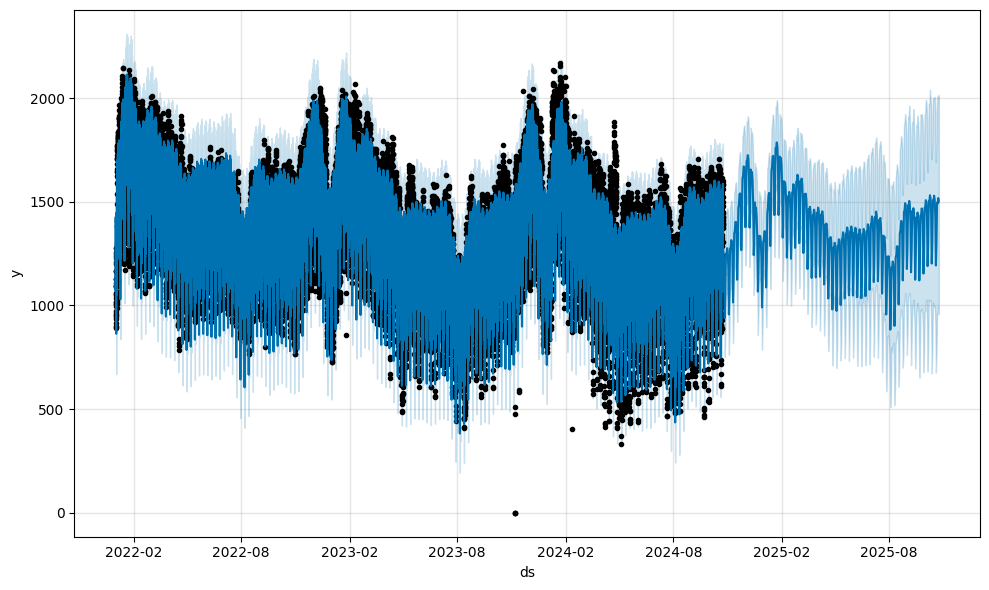

In [17]:
# Python
fig1 = m.plot(forecast)

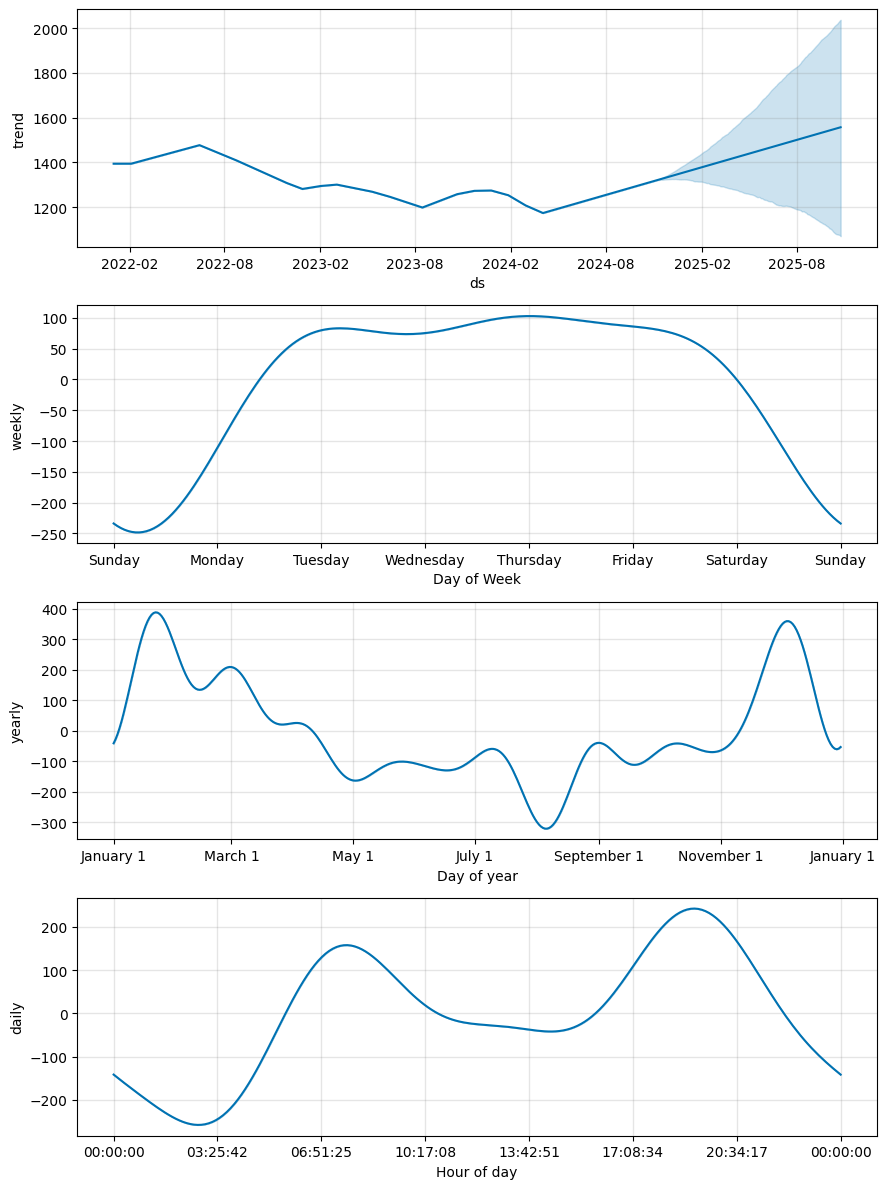

In [18]:
# Python
fig2 = m.plot_components(forecast)

In [20]:
from neuralprophet import NeuralProphet, set_log_level

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [21]:
m = NeuralProphet(
    n_changepoints=0,
    weekly_seasonality=True,
)
m.set_plotting_backend("plotly-static")
metrics = m.fit(df_hourly, freq="60min")
future = m.make_future_dataframe(df_hourly, periods=7 * 24, n_historic_predictions=True)
forecast = m.predict(future)
m.plot(forecast)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.98% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I 

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (193) is too small than the required number                     for the learning rate finder (259). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 44. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 259/259 [00:02<00:00, 92.27it/s] 


Training: |          | 0/? [00:56<?, ?it/s, v_num=0, train_loss=0.0117, reg_loss=0.000, MAE=134.0, RMSE=172.0, Loss=0.0117, RegLoss=0.000] 

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.98% of the data.
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated 

INFO - (NP.data.processing._handle_missing_data) - Dropped 168 rows at the end with NaNs in 'y' column.


Predicting DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 157.17it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\neuralprophet\plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed